In [ ]:
# from astropy.time import Time, TimeDelta
# from astropy.coordinates import AltAz, ICRS, EarthLocation, Angle, FK5, SkyCoord
# import astropy.units as u
# from lsst.obs.lsst.translators.latiss import AUXTEL_LOCATION
# from lsst.daf.butler import Butler
# import lsst.afw.math as afwMath
# from astropy.io import fits
# from lsst.ip.isr.isrTask import IsrTask
# from lsst.summit.utils import BestEffortIsr
# butler = Butler('/repo/main', collections="LATISS/raw/all")
        # best_effort_isr.doWrite = False  # Don't write to butler database
        # self.postISR = best_effort_isr.getExposure(dataId, skipCosmics=False)

In [3]:
# date_beg = Time(mData['DATE-BEG'], format='isot', scale='tai')
# time = date_beg.utc

In [1]:
import sys, time, os, asyncio, glob
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import lsst.afw.detection as afwDetect
from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask, CharacterizeImageConfig

import lsst.summit.utils.butlerUtils as butlerUtils
from lsst.summit.utils.utils import detectObjectsInExp
import pandas as pd

from lsst.pipe.base import TaskError

%matplotlib inline

In [2]:
def detectObjectsInExpFunc(exp, nSigma=10, nPixMin=10, grow=0):
    """Return the footPrintSet for the objects in a postISR exposure."""
    median = np.nanmedian(exp.image.array)
    exp.image -= median * 100

    threshold = afwDetect.Threshold(nSigma, afwDetect.Threshold.STDEV)
    footPrintSet = afwDetect.FootprintSet(exp.getMaskedImage(), threshold, "DETECTED", nPixMin)
    if grow > 0:
        isotropic = True
        footPrintSet = afwDetect.FootprintSet(footPrintSet, grow, isotropic)

    exp.image += median * 100  # add back in to leave background unchanged
    return footPrintSet

In [12]:
class sttrdImg():
    """Analysis class for stuttered images taken at AuxTel."""
    def __init__(self, expId, shift=50):
        obsdate = int(str(expId)[:8])
        seq_num = int(str(expId)[8:])
        
        # best_effort_isr = BestEffortIsr()
        dataId = {'day_obs': obsdate, 'seq_num': seq_num, 'detector': 0, "instrument": 'LATISS'}
        
        self.postISR = butler.get('quickLookExp', dataId)
        self.mData = self.postISR.getMetadata()
        
        self.shift = 50
        self.pixels = self.postISR.image.array.shape
        self.mid = int(self.pixels[0] / 2)
        self.Nstrips = int(self.mid / 50)
        
        self.strips = self.getStrips()
        
    def display(self, ax, vmin, vmax):
        arr = self.postISR.image.array
        img = ax.imshow(arr, norm=LogNorm(vmin=vmin, vmax=vmax),  interpolation='Nearest', cmap='gray')
        return ax

    def getStripCoords(self):
        # move up from midline:
        startendUP = [(int(s), int(s + self.shift)) 
                      for s in np.linspace(self.mid, self.mid + (self.Nstrips - 1) * self.shift, self.Nstrips)]
        # move down from midline:
        startendDOWN = [(int(s - self.shift), int(s)) 
                        for s in np.linspace(self.mid, self.mid - (self.Nstrips - 1) * self.shift, self.Nstrips)]
        
        return startendUP + startendDOWN
    
    def displayStrips(self, ax):
        pairs = self.getStripCoords()
        
        [ax.axhline(x) for x,_ in pairs]
        ax.axhline(pairs[-1][1])
        return ax
    
    def getStrips(self):
        pairs = self.getStripCoords()
        strips = {}
        
        img = self.postISR    
        for up, down in zip(pairs[self.Nstrips:], pairs[:self.Nstrips]):
            strips[up[0]] = img[:, up[0]:up[1]]
            strips[down[0]] = img[:, down[0]:down[1]]
            
        return strips
    
    def getPostageCenters(self):
        centroids = {}
        for k, s in self.strips.items():
            ftpts = detectObjectsInExpFunc(s).getFootprints()
            centroids[k] = [f.getCentroid() for f in ftpts]
        self.centroidsRough = centroids

        x_coords = []
        [[x_coords.append(c.x) for c in cl] for k, cl in centroids.items() if len(cl)!=0]
        x_coords = np.sort(x_coords)
        mid = np.searchsorted(x_coords, np.median(x_coords))

        return np.median(x_coords[mid:]), np.median(x_coords[:mid])

    def getPostageStamps(self, x):
        xLow, xHigh = int(x - self.shift/2), int(x + self.shift/2)
        stamps = {}
        for k, s in self.strips.items():
            stamps[k] = s[xLow:xHigh, :]
        return stamps
        
    def runCharExp(self, exp, fwhm=1.0, minPix=10):
        charConfig = CharacterizeImageConfig()
        charConfig.installSimplePsf.fwhm = fwhm
        charConfig.doMeasurePsf = False
        charConfig.doApCorr = False
        charConfig.doDeblend = False
        charConfig.repair.doCosmicRay = True
        charConfig.repair.cosmicray.nCrPixelMax=100000
        charConfig.repair.doInterpolate = False   
        charConfig.detection.background.binSize = 5 #15#32
        charConfig.detection.minPixels = minPix
        charTask = CharacterizeImageTask(config=charConfig)
        
        try:
            charResult = charTask.run(exp)
            spotCatalog = charResult.sourceCat
            return spotCatalog.asAstropy().to_pandas()
        except TaskError as e:
            print('a failure occured!')
            raise e
    
    def runDetect(self):
        c = {}
        for x_center in self.getPostageCenters():
            stamp_cats = {}
            for i, stamp in self.getPostageStamps(x_center).items():
                try:
                    stamp_cats[i] = self.runCharExp(stamp)
                except TaskError:
                    print('bloop')
            catalog = pd.concat(stamp_cats)

            xx_key = 'ext_shapeHSM_HsmSourceMoments_xx'
            yy_key = 'ext_shapeHSM_HsmSourceMoments_yy'
            xy_key = 'ext_shapeHSM_HsmSourceMoments_xy'
            # catalog['size'] = catalog.apply(lambda row: np.power(row[xx_key]*row[yy_key]-row[xy_key]**2,0.25))
            # catalog['e1'] = catalog.apply(lambda row: (row[xx_key] - row[yy_key])/(row[xx_key] + row[yy_key]))
            # catalog['e2'] = catalog.apply(lambda row: 2 * row[xy_key]/(row[xx_key] + row[yy_key]))
        
            c[x_center] = catalog
        self.catalogs = c
        return


In [4]:
butler = butlerUtils.makeDefaultLatissButler(oga=True)

extraWhere = "exposure.observation_type='stuttered'"
seqNums = butlerUtils.getSeqNumsForDayObs(butler, 20221012, extraWhere=extraWhere)

# seqNums

### Load image into class, display image, and characterize background

In [13]:
expid = 2022101200472
img = sttrdImg(expid)

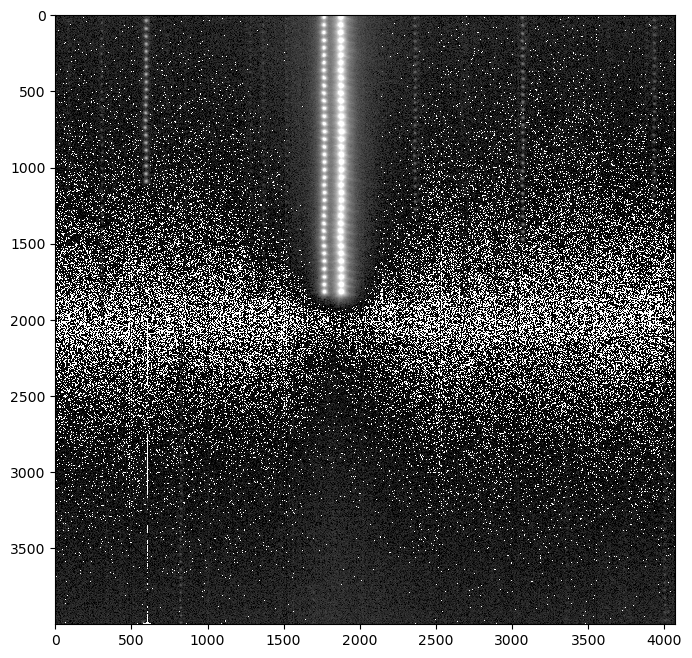

In [14]:
f, ax = plt.subplots(1,1,figsize=(8,8))
img.display(ax, vmin=10, vmax=10000)
    
# plt.savefig(f'../plots/{expid}_isrimg.png',dpi=200)
plt.show()             

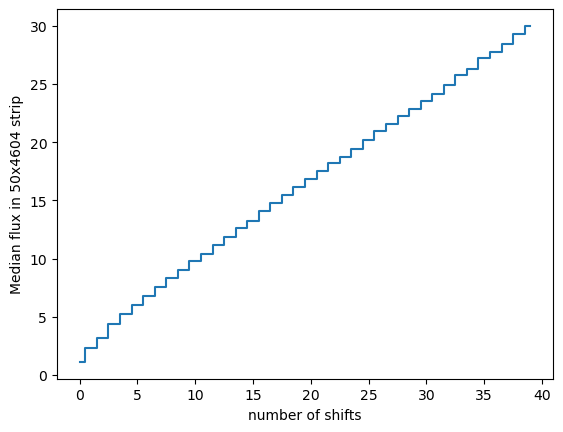

In [137]:
strips = img.getStrips()
keys = [k for k in strips.keys()]
fluxes = np.array([np.median(v.image.array) for k,v in strips.items()])[np.argsort(keys)]
plt.plot(range(img.Nstrips), (fluxes[40:] + fluxes[:40][::-1])/2, ds='steps-mid')

plt.xlabel("number of shifts")
plt.ylabel("Median flux in 50x4604 strip")
# plt.savefig(f'../plots/{expid}_fluxes.png',dpi=200)
plt.show()

### Run simple detection on the image

In [ ]:
# TO DO
# what if only one star gets detected? 
# or more than 2? -> select only the two brightest. 
# - How, at this stage? something in the footprints can tell us?

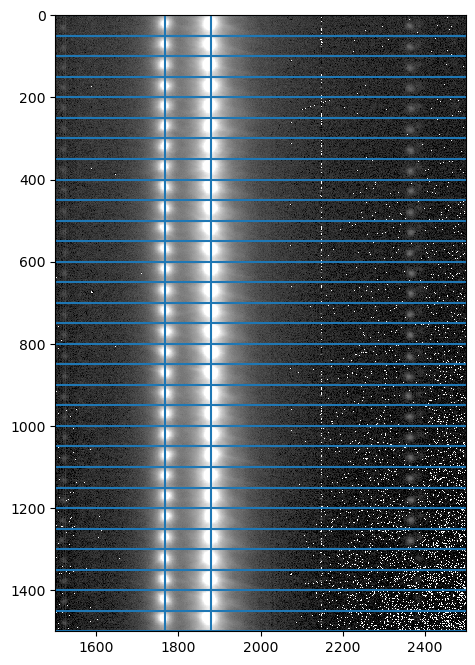

In [15]:
zoom = 1
f, ax = plt.subplots(1,1,figsize=(8,8))
img.display(ax, vmin=10, vmax=10000)

if zoom:
    img.displayStrips(ax)
    ax.set_xlim(1500,2500)
    ax.set_ylim(1500,0)

[ax.axvline(x_val) for x_val in img.getPostageCenters()]

# if zoom:
#     plt.savefig(f'../plots/{expid}_detections_zoom.png',dpi=200)
# else:
#     plt.savefig(f'../plots/{expid}_detections.png',dpi=200)
plt.show()

### Use detection centers to generate postage stamps

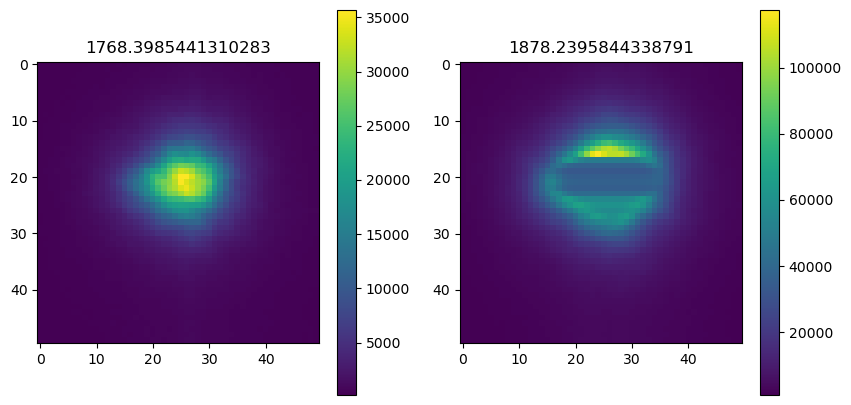

In [16]:
x2, x1 = img.getPostageCenters()
stamps1 = img.getPostageStamps(x1)
stamps2 = img.getPostageStamps(x2)

y = [s for s in stamps1.keys()][12]

f, a = plt.subplots(1, 2, figsize=(10,5))

im1 = a[0].imshow(stamps1[y].image.array)
plt.colorbar(im1, ax=a[0])
a[0].set_title(x1)

im2 = a[1].imshow(stamps2[y].image.array)
plt.colorbar(im2, ax=a[1])
a[1].set_title(x2);

In [17]:
detectObjectsInExp(stamps1[y]), detectObjectsInExp(stamps2[y])

(1 footprints:
 1 peaks, area=243, centroid=(1768.29, 1671.16),
 2 footprints:
 2 peaks, area=66, centroid=(1879.26, 1665.32)
 5 peaks, area=78, centroid=(1877.62, 1675.42))

In [18]:
d1 = img.runCharExp(stamps1[y], minPix=5)

### Run detection/characterization on postage stamps

In [184]:
img.runDetect()

a failure occured!
bloop


a failure occured!
bloop


a failure occured!
bloop


a failure occured!
bloop


In [ ]:
# for strip, obj in img.catalog.index:
#     c = img.catalog.loc[strip, obj]
#     ax.plot(c['ext_shapeHSM_HsmSourceMoments_x'], c['ext_shapeHSM_HsmSourceMoments_y'], 'bx', alpha=0.5)

# spotIds = img.catalog.index[abs(img.catalog['ext_shapeHSM_HsmSourceMoments_x']-2350) < 100]
# spots = img.catalog.loc[spotIds]

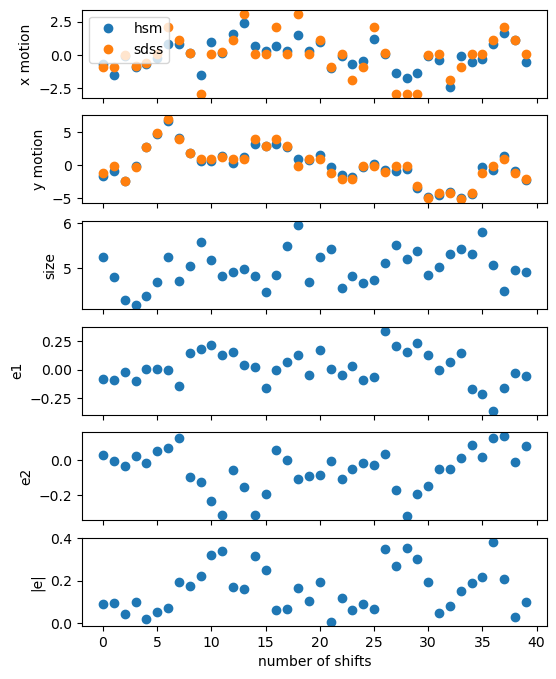

In [17]:
# f, a = plt.subplots(6,1, sharex=True, figsize=(6, 8))

# for star_x, spots in img.catalogs.items():
#     shifts = np.array([i for i,j in spots.index]) / 50
#     a[0].plot(shifts, spots['ext_shapeHSM_HsmSourceMoments_x'] - np.mean(spots['ext_shapeHSM_HsmSourceMoments_x']), 'o')

#     y_hsm = spots['ext_shapeHSM_HsmSourceMoments_y'] - shifts*50
#     a[1].plot(shifts, y_hsm - np.mean(y_hsm), 'o')

#     a[2].plot(shifts, spots['size'], 'o')    
#     a[3].plot(shifts, spots['e1'], 'o')
#     a[4].plot(shifts, spots['e2'], 'o')
#     a[5].plot(shifts, np.hypot(spots['e1'], spots['e2']), 'o')
    
# a[0].set_ylabel('x motion')
# a[0].legend()
# a[1].set_ylabel('y motion')
# a[2].set_ylabel('size')
# a[3].set_ylabel('e1')
# a[4].set_ylabel('e2')
# a[5].set_ylabel('|e|')
# a[5].set_xlabel('number of shifts')

# # plt.savefig(f'../plots/{expid}_psfparams.png',dpi=200)
# plt.show()